In [1]:
#Vision Model
#TF imports
import tensorflow as tf
from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Dense, ReLU, Input, GaussianNoise, BatchNormalization, AveragePooling2D
#from tensorflow.keras.layers import Conv2D, Flatten, Softmax, MaxPooling2D, Lambda, Subtract, UpSampling2D, Reshape, Dropout, Add, Concatenate
#from tensorflow.keras.regularizers import l2
from keras.utils.np_utils import to_categorical

from tensorflow.keras.mixed_precision import experimental as mixed_precision

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.config.optimizer.set_experimental_options(
    {"auto_mixed_precision": True})

#Util imports
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
from skimage.transform import resize
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from skimage.transform import rescale, resize, downscale_local_mean


#File configuration
path ='D:Hackathons/HackNow/'

'''# Tensorflow gpu configuration
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
'''
'''config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)'''



Using TensorFlow backend.


'config = ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 1.0\nconfig.gpu_options.allow_growth = True\nsession = InteractiveSession(config=config)'

In [5]:
path ='D:Hackathons/HackNow/'
X_train = np.load(path+'X_train_data.npy')
X_test = np.load(path+"X_test_data.npy")
y_train=np.load(path+'y_train.npy')
y_test=np.load(path+'y_test.npy')

In [3]:
train_datagen = ImageDataGenerator(
        shear_range=0.01,
        zoom_range=0.2,
        rotation_range=30,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=False,
        vertical_flip=False,
)

#train_datagen.fit(x_train)

In [4]:
X = np.load("D:Hackathons/HackNow/X_train.npy")
X = np.array([rescale(X[i], 0.333) for i in range(X.shape[0])])
print('scaled')
X = X.reshape((X.shape[0],250,250,1)) * np.ones((1,1,1,3), dtype='uint8')
y = np.load("D:Hackathons/HackNow/y_train.npy")
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size= .2)
print(X.shape)
plt.imshow(X_train[0])
plt.show()

KeyboardInterrupt: 

In [11]:
#Model
input_shape = (250,250,3)

def COVID_Model():
    # load model
    i = tf.keras.layers.Input(shape=input_shape)
    gn = tf.keras.layers.GaussianNoise(.1, dtype = 'float32')(i)
    y = tf.keras.layers.ReLU(max_value = 1)(i)
    y = tf.keras.layers.Lambda(lambda y:y*1.)(y)
    #y = tf.keras.layers.MaxPooling2D((3,3))(y)

    model = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=y, pooling=None, classes=3)
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation = 'relu',padding = 'same')(model.layers[-2].output)
    flat1 = tf.keras.layers.Dropout(.2)(flat1)
    flat1 = tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation = 'relu',padding = 'same')(flat1)
    flat1 = tf.keras.layers.MaxPooling2D((2,2))(flat1)
    flat1 = tf.keras.layers.Conv2D(128, kernel_size = (1,1), activation = 'relu')(flat1)
    flat1 = tf.keras.layers.Conv2D(128, kernel_size = (2,2), activation = 'relu',padding='same')(flat1)
    flat1 = tf.keras.layers.Flatten()(flat1)
    flat1 = tf.keras.layers.Dropout(.2)(flat1)
    
    class2 = tf.keras.layers.Dense(255, activation='relu')(flat1)
    
    output = tf.keras.layers.Dense(3, activation='softmax', dtype='float32', name ='out')(class2)
    model = Model(inputs=i, outputs = output)
    
    return model

def VGG_small():

    # load model
    i = tf.keras.layers.Input(shape=input_shape)
    gn = tf.keras.layers.GaussianNoise(.1, dtype = 'float32')(i)
    y = tf.keras.layers.ReLU(max_value = 1)(i)

    #model = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=y, pooling=None, classes=2)

    #model = VGGFace(include_top=False, model = 'resnet50',weights = 'vggface', input_tensor = y)
    #model = tf.keras.applications.Xception(include_top = False, weights='imagenet', input_tensor = y)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(y)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # Block 2
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(
        x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(
        x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    # Block 3
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(
        x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(
        x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(
        x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

    # Block 4
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(
        x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(
        x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(
        x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

    # Block 5
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(
        x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(
        x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(
        x)
    
    
    # mark loaded layers as not trainable

    #for layer in model.layers:
    #    layer.trainable = False
        
    #for i in range(0):
    #    model.layers[i].trainable = False
    
    
    # add new classifier layers
    flat1 = tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation = 'relu',padding = 'same')(x)
    flat1 = tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation = 'relu',padding = 'same')(flat1)
    flat1 = tf.keras.layers.MaxPooling2D((2,2))(flat1)
    flat1 = tf.keras.layers.Conv2D(128, kernel_size = (1,1), activation = 'relu')(flat1)
    flat1 = tf.keras.layers.Conv2D(128, kernel_size = (2,2), activation = 'relu',padding='same')(flat1)
    flat1 = tf.keras.layers.MaxPooling2D((2,2))(flat1)
    #flat1 = GaussianNoise(0)(flat1)
    flat1 = tf.keras.layers.Flatten()(flat1)
    flat1 = tf.keras.layers.Dropout(.2)(flat1)
    
    class2 = tf.keras.layers.Dense(255, activation='relu')(flat1)
    #class3 = Dense(250, activation = 'relu')(class2)
    #class4 = Dense(250, activation = 'relu')(class3)
    
    output = tf.keras.layers.Dense(3, activation='softmax', dtype='float32')(class2)
    model = Model(inputs=i, outputs = output)
    #model.summary()

    
    # define new model
    
    #o = model(y)
    #model.summary()
    #model = Model(inputs=x, outputs=o)
    
    return model


model_c = VGG_small()

opt = tf.keras.optimizers.Adam(0.00004)

model_c.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer= opt,
              metrics=['categorical_accuracy'],
              weighted_metrics=['categorical_crossentropy','mean_absolute_error'])

#model_c.summary()

In [22]:
hist = model_c.fit(train_datagen.flow(X_train,y_train, batch_size=1),validation_data=(X_test,y_test),epochs=25)

Epoch 1/25
4228/4228 [==============================] - 80s 19ms/step - loss: 0.5074 - categorical_accuracy: 0.7715 - categorical_crossentropy: 0.5074 - mean_absolute_error: 0.2099 - val_loss: 0.4519 - val_categorical_accuracy: 0.7940 - val_categorical_crossentropy: 0.4519 - val_mean_absolute_error: 0.1749
Epoch 2/25
4228/4228 [==============================] - 81s 19ms/step - loss: 0.4986 - categorical_accuracy: 0.7855 - categorical_crossentropy: 0.4986 - mean_absolute_error: 0.2042 - val_loss: 0.4505 - val_categorical_accuracy: 0.7996 - val_categorical_crossentropy: 0.4505 - val_mean_absolute_error: 0.1830
Epoch 3/25
4228/4228 [==============================] - 80s 19ms/step - loss: 0.4940 - categorical_accuracy: 0.7779 - categorical_crossentropy: 0.4940 - mean_absolute_error: 0.2041 - val_loss: 0.4667 - val_categorical_accuracy: 0.8062 - val_categorical_crossentropy: 0.4667 - val_mean_absolute_error: 0.2135
Epoch 4/25
4228/4228 [==============================] - 80s 19ms/step - loss

KeyboardInterrupt: 

In [21]:
model_c.save('COVID_val80.h5')

In [23]:
import sklearn
p = model_c.predict(X_test)
preds = [np.argmax(p[i]) for i in range(len(X_test))]
Ys = [np.argmax(y_test[i]) for i in range(len(X_test))]
diff = np.abs(np.array(preds)-np.array(Ys))
diff = (diff<1)

matrix = sklearn.metrics.confusion_matrix(preds,Ys, normalize = 'true')
print(matrix)

[[0.93165468 0.02158273 0.04676259]
 [0.00508475 0.77118644 0.22372881]
 [0.02631579 0.22105263 0.75263158]]


(250, 250)
[[5.4099064e-06 8.5824150e-01 1.4175305e-01]]
[0. 1. 0.]


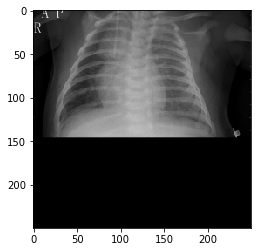

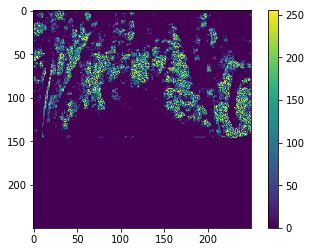

(250, 250)
[[2.1402218e-05 9.3550450e-01 6.4474098e-02]]
[0. 1. 0.]


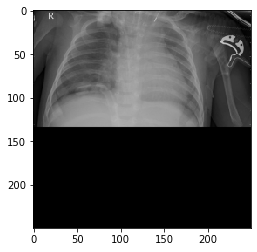

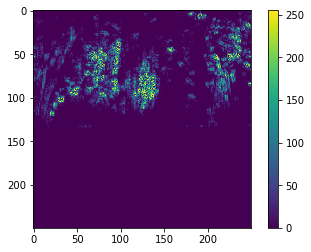

(250, 250)
[[0.00898887 0.34288257 0.6481286 ]]
[0. 1. 0.]


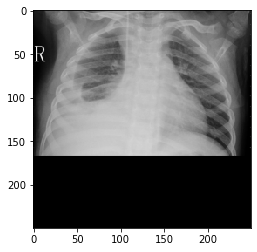

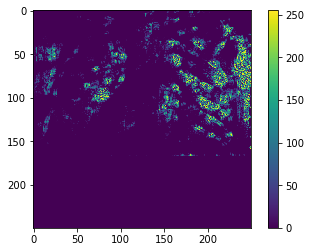

(250, 250)
[[9.2785900e-05 8.2719648e-01 1.7271076e-01]]
[0. 0. 1.]


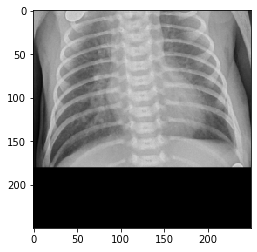

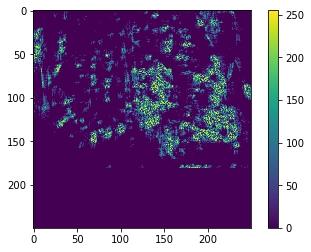

(250, 250)
[[3.2140044e-04 9.2479867e-01 7.4879959e-02]]
[0. 0. 1.]


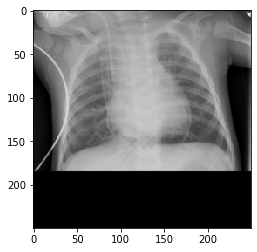

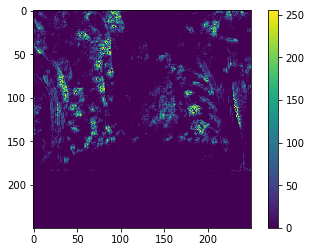

(250, 250)
[[0.00485963 0.7873345  0.20780586]]
[0. 1. 0.]


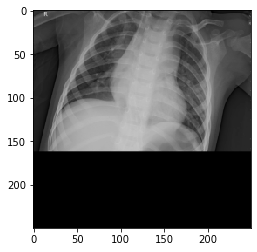

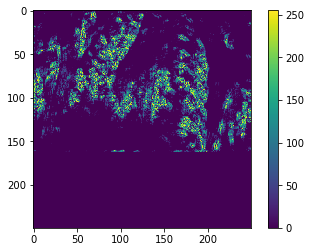

(250, 250)
[[3.4322104e-04 9.3320256e-01 6.6454299e-02]]
[0. 0. 1.]


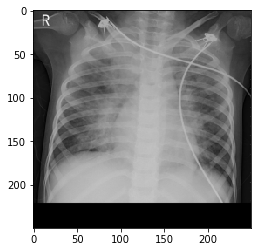

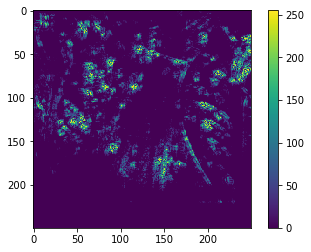

(250, 250)
[[0.7790143  0.04737167 0.17361407]]
[1. 0. 0.]


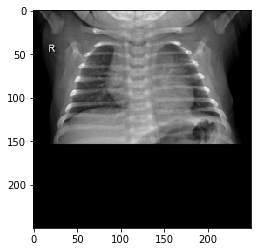

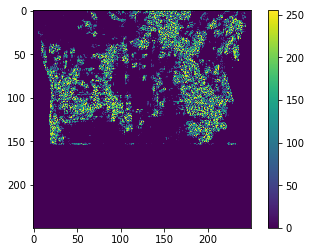

(250, 250)
[[1.0286310e-04 9.2062503e-01 7.9272136e-02]]
[0. 1. 0.]


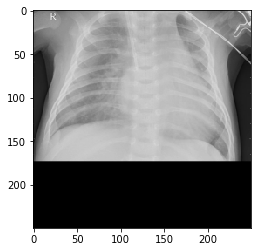

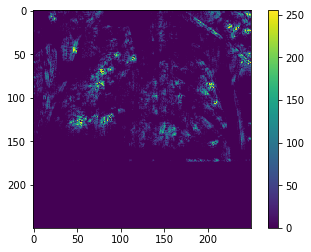

(250, 250)
[[3.5530647e-05 9.2196059e-01 7.8003854e-02]]
[0. 0. 1.]


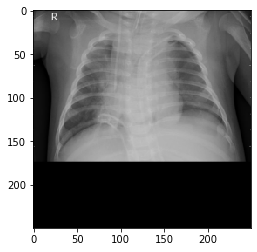

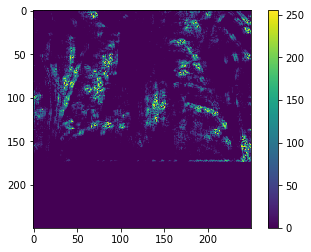

In [27]:
import tf_explain.core.vanilla_gradients as vgmod

vg = vgmod.VanillaGradients()

for i in range(500,510):
    item = (X_train[i:i+1],y_train[i])
    #plt.imshow(item[0].reshape(250,250,3))
    #plt.show()

    x = vg.explain((item[0],item[1]),model_c,1)

    print(x.shape)
    print(model_c.predict(item[0]))
    print(item[1])
    plt.imshow(item[0].reshape(250,250,3))
    plt.show()
    plt.imshow(x)
    plt.colorbar()
    plt.show()

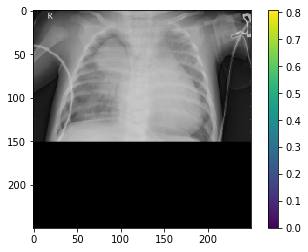

In [12]:
plt.imshow(X_train[510])
plt.colorbar()

In [9]:
model_c.save('thismodelSucksless.h5')

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import numpy as np
import PIL
from PIL import Image
from skimage.transform import resize


path = ''
model = load_model(path + 'thismodelSucks.h5')
def infer(image):
    y = model.predict(image.reshape(1,250,250,3))[0]
    print(y)
    pred = np.argmax(y)
    
    if pred == 0:
        n = 'Normal'
    elif pred ==1:
        n = 'Bacterial'
    elif pred == 2:
        n = 'Viral'
    
    #returns diagnosis and confidence
    return (n, y[pred])

#will take any image(as np array) in any shape(3d)(width,height,channel(s))
def image_process(i):
    image = i
    base = 250
    array_dimension = [1,base,base,1]
    full_image_array = np.zeros(array_dimension)
    
    width = image.shape[0]
    height = image.shape[1]
    max_value = [width,height]
    max_value = max(max_value)
    ratio = base/max_value
    width_d = int(width*ratio)
    height_d = int(height*ratio)
    int_max = max(width_d,height_d)
    if int_max < base:
        if int_max == width_d:
            width_d = base
        elif int_max == height_d:
            height_d = base
        elif int_max == width_d == height_d:
            width_d = base
            height_d = base
    #print(width,height,width_d, height_d)
    image = np.array(resize(image,(width_d,height_d))) 
    zeros = np.zeros((base,base))
    zeros[:image.shape[0], :image.shape[1]] = (image if len(image.shape)==2 else image[:,:,0])
    image = zeros
    
    '''if(len(image.shape)==3):
        full_image_array = np.concatenate([full_image_array,image[:,:,0].reshape(array_dimension)],axis=0)
    else:'''
    full_image_array = np.concatenate([full_image_array,image.reshape(array_dimension)],axis=0)
        
    X = full_image_array[1:]
    X = X.reshape((X.shape[0],250,250,1)) * np.ones((1,1,1,3), dtype='uint8')
    return X

In [78]:
print(infer(image_process(X_train[0])))

250 250 250 250
[0.06233364 0.45860615 0.4790603 ]
('Viral', 0.4790603)


In [75]:
img = np.array(Image.open('testimg.jpg'))
processed = image_process(img)

1820 2048 222 250


In [72]:
x = np.array([[[0]]])
print(x.shape)
print(x[:,:,:,0])

(1, 1, 1)


IndexError: too many indices for array

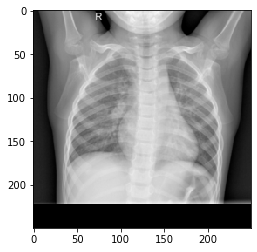

In [77]:
plt.imshow(processed[0])

In [8]:
print(model_c.predict(X_train[0:10]))

[[1.1700832e-05 9.3330115e-01 6.6687137e-02]
 [1.6220605e-05 9.2826670e-01 7.1717039e-02]
 [9.2643757e-05 8.9471072e-01 1.0519666e-01]
 [6.1788072e-05 9.1702688e-01 8.2911402e-02]
 [8.8201982e-01 5.6314435e-02 6.1665680e-02]
 [9.4077009e-01 2.0336704e-02 3.8893260e-02]
 [2.9436855e-05 9.2308438e-01 7.6886110e-02]
 [9.8679972e-01 3.0254829e-03 1.0174834e-02]
 [9.6348500e-01 7.5433054e-03 2.8971706e-02]
 [2.8937081e-02 2.7021340e-01 7.0084953e-01]]
